In [1]:
from google.colab import files
uploaded = files.upload()

Saving cat-dog-images.zip to cat-dog-images.zip


In [2]:
import zipfile
import os
zip_path = "/content/cat-dog-images.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)

Unzipped to: /content/data


In [3]:
!ls /content/data

test  train


In [4]:
!ls /content/data/train
!ls /content/data/test

cats  dogs
cats  dogs


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define transformations (Resize, Normalize, Augment)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset from your extracted folder
train_dataset = datasets.ImageFolder("/content/data/train", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/data/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))
print("Classes:", train_dataset.classes)

Train size: 557
Test size: 140
Classes: ['cats', 'dogs']


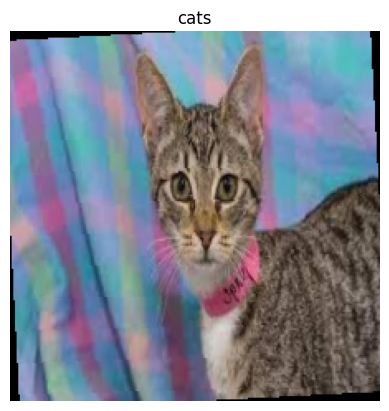

In [7]:
def imshow(img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0], train_dataset.classes[labels[0]])


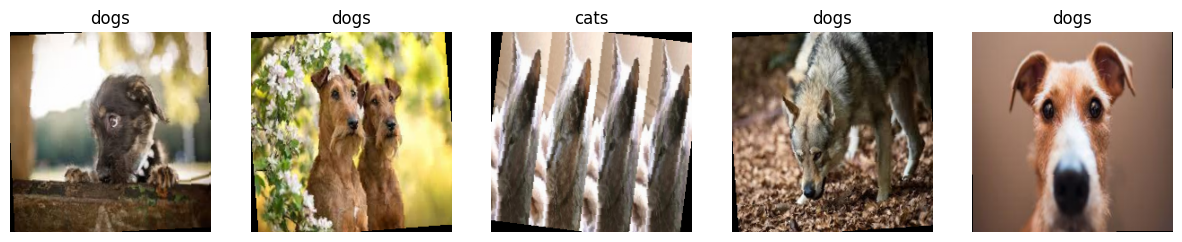

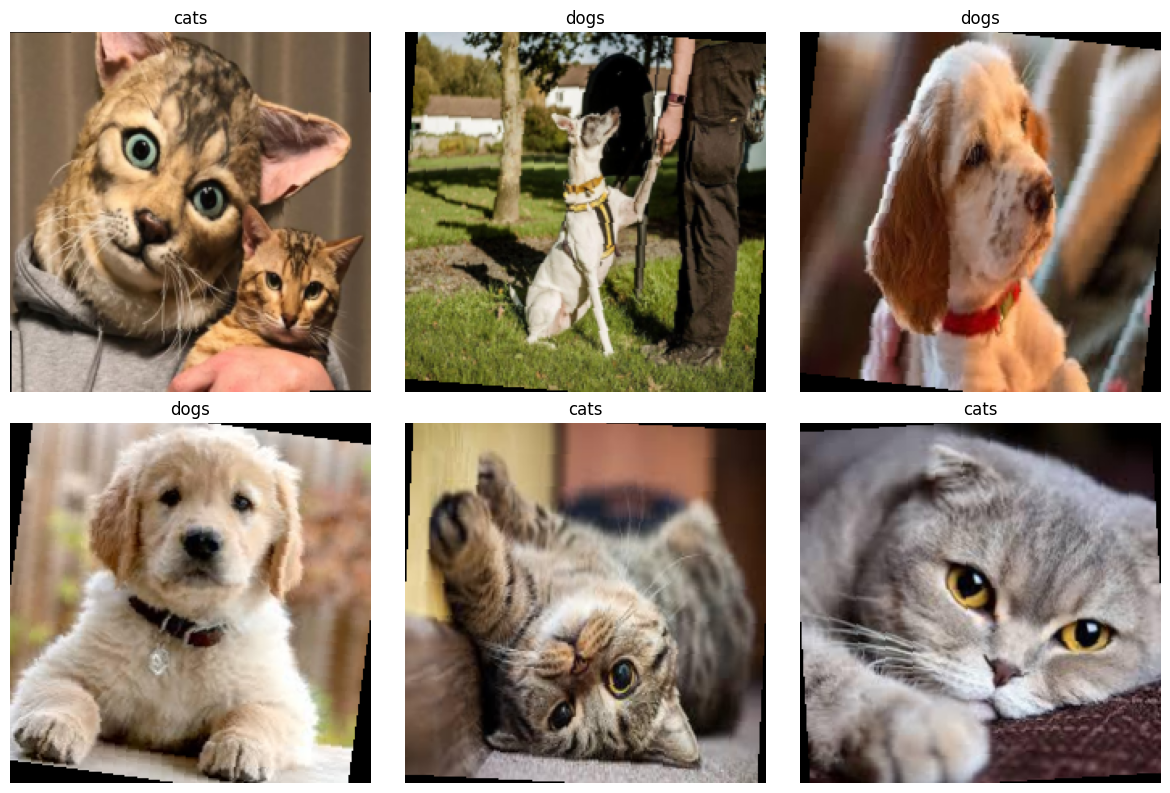

In [8]:
def show_multiple_images(num_images=5):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i] / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i].set_title(train_dataset.classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_multiple_images()


# Display a grid of images
def show_image_grid(num_rows=2, num_cols=3):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index] / 2 + 0.5
                npimg = img.numpy()
                axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
                axes[i, j].set_title(train_dataset.classes[labels[index]])
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_image_grid()


In [9]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Use test_transform (no augmentation) for validation
val_subset.dataset.transform = test_transform

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


In [10]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: cat and dog
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.0MB/s]


In [11]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Reduce LR if validation loss doesn't improve
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


In [12]:
import copy
num_epochs = 10
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best model after training
model.load_state_dict(best_model_wts)


Epoch 1/10: Train Loss=0.4292, Acc=84.27%, Val Loss=2.2055, Acc=75.00%
Epoch 2/10: Train Loss=0.3421, Acc=85.84%, Val Loss=2.5307, Acc=64.29%
Epoch 3/10: Train Loss=0.2310, Acc=91.24%, Val Loss=1.3605, Acc=78.57%
Epoch 4/10: Train Loss=0.1446, Acc=93.93%, Val Loss=0.4337, Acc=84.82%
Epoch 5/10: Train Loss=0.1079, Acc=95.51%, Val Loss=0.4495, Acc=86.61%
Epoch 6/10: Train Loss=0.0472, Acc=97.98%, Val Loss=0.6135, Acc=83.93%
Epoch 7/10: Train Loss=0.0217, Acc=98.88%, Val Loss=0.3304, Acc=88.39%
Epoch 8/10: Train Loss=0.0108, Acc=100.00%, Val Loss=1.1132, Acc=75.89%
Epoch 9/10: Train Loss=0.0755, Acc=98.65%, Val Loss=0.5277, Acc=84.82%
Epoch 10/10: Train Loss=0.0676, Acc=97.98%, Val Loss=0.5117, Acc=88.39%


<All keys matched successfully>

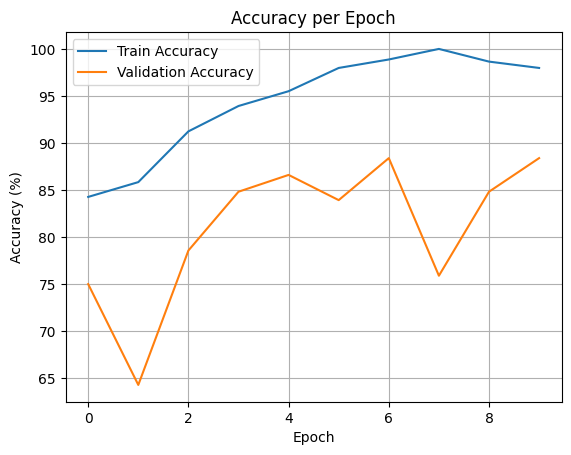

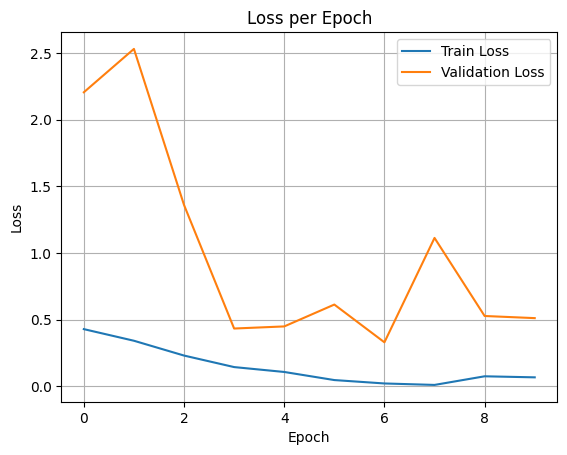

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation (Enhanced)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = datasets.ImageFolder("/content/data/train", transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 2)
)
model = model.to(device)

class_weights = torch.tensor([1.0, 2.0]).to(device)  # [cat, dog]
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer + Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Train with Early Stopping
num_epochs = 15
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_epoch = 0  # Variable to store the epoch with the best accuracy
wait = 0
patience = 3

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}%, Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%, Loss: {val_loss:.4f}")

    # Save best model & early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch + 1  # Store the epoch with the best accuracy
        best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break
model.load_state_dict(best_model_wts)

# Save the best model after training finishes at the best epoch
torch.save(best_model_wts, f'best_resnet18_model_epoch_{best_epoch}.pth')
print(f"Best model saved to 'best_resnet18_model_epoch_{best_epoch}.pth' with Accuracy: {best_acc:.2f}%")


Epoch 1/15 | Train Acc: 80.00%, Loss: 0.4702 | Val Acc: 51.79%, Loss: 9.0737
Epoch 2/15 | Train Acc: 87.19%, Loss: 0.3124 | Val Acc: 87.50%, Loss: 1.3736
Epoch 3/15 | Train Acc: 90.34%, Loss: 0.2085 | Val Acc: 85.71%, Loss: 0.7070
Epoch 4/15 | Train Acc: 94.83%, Loss: 0.0931 | Val Acc: 89.29%, Loss: 0.2653
Epoch 5/15 | Train Acc: 98.20%, Loss: 0.0425 | Val Acc: 82.14%, Loss: 0.6815
Epoch 6/15 | Train Acc: 98.20%, Loss: 0.0362 | Val Acc: 91.96%, Loss: 0.3139
Epoch 7/15 | Train Acc: 99.55%, Loss: 0.0166 | Val Acc: 88.39%, Loss: 0.3933
Epoch 8/15 | Train Acc: 99.78%, Loss: 0.0072 | Val Acc: 89.29%, Loss: 0.2689
Epoch 9/15 | Train Acc: 99.55%, Loss: 0.0120 | Val Acc: 91.07%, Loss: 0.2664
Early stopping triggered.
Best model saved to 'best_resnet18_model_epoch_6.pth' with Accuracy: 91.96%


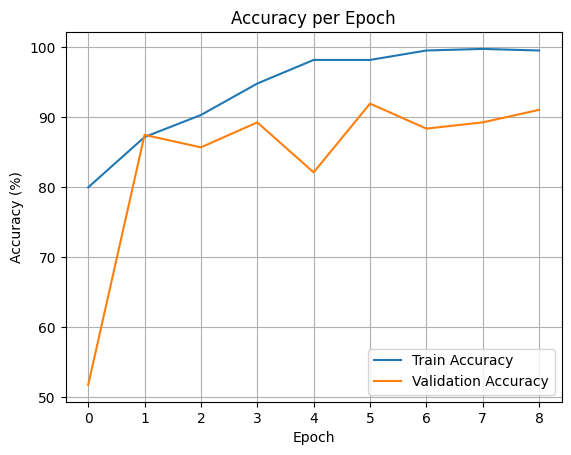

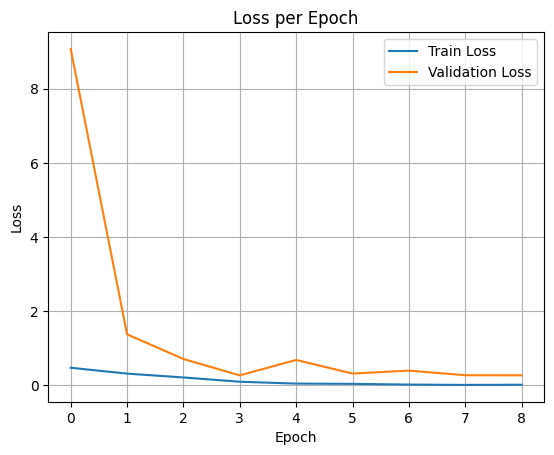

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [18]:
# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model = model.to(device)

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

#  test accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f" Test Accuracy: {test_acc * 100:.2f}%")


 Test Accuracy: 91.43%


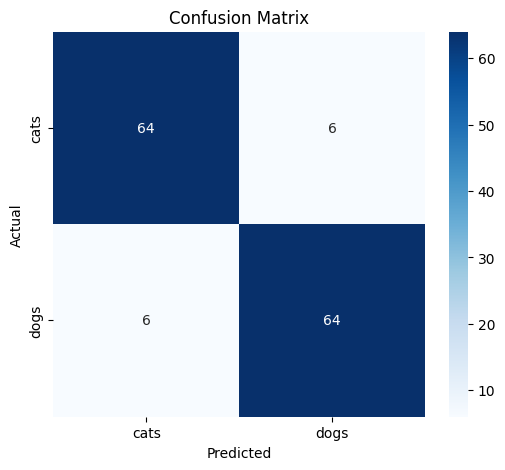

In [19]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = test_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


 Total Misclassified: 12


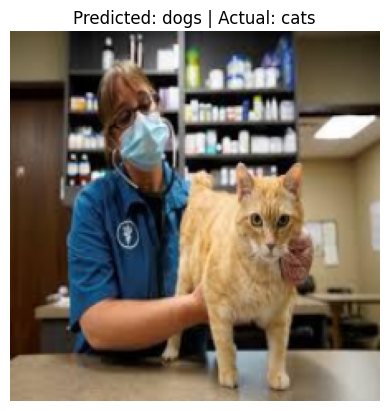

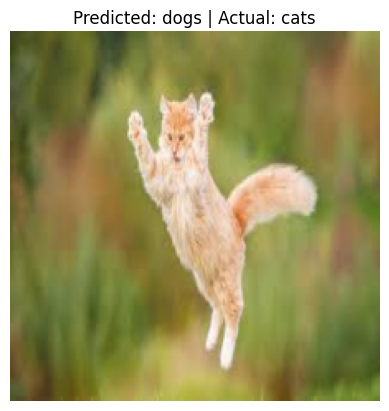

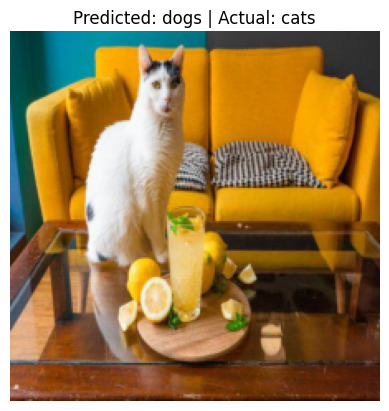

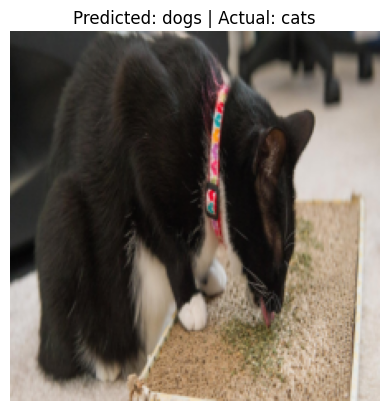

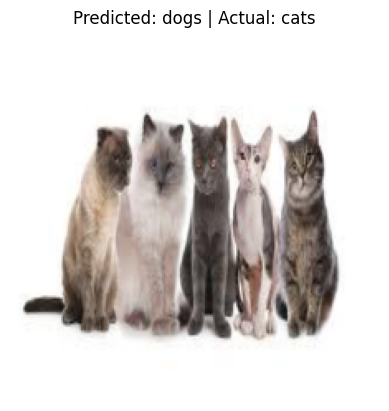

In [20]:
# misclassified images
def show_misclassified(model, test_loader, class_names, num_images=5):
    model.eval()
    model.to(device)
    misclassified = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((inputs[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    print(f" Total Misclassified: {len(misclassified)}")

    for i in range(min(num_images, len(misclassified))):
        img, pred, actual = misclassified[i]
        img = img * 0.5 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"Predicted: {class_names[pred]} | Actual: {class_names[actual]}")
        plt.axis('off')
        plt.show()

show_misclassified(model, test_loader, class_names, num_images=5)

In [22]:
from google.colab import files
uploaded = files.upload()  # Upload a .jpg or .png file

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

def predict_image(path):
    img = Image.open(path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    predicted_class = class_names[pred.item()]

    print(f" Prediction: {predicted_class}")
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

Saving dog_123.jpg to dog_123.jpg
Saving dog_464.jpg to dog_464.jpg


 Prediction: dogs


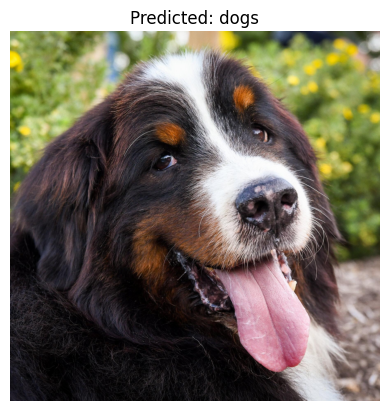

In [26]:
predict_image("dog_464.jpg")


In [27]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [29]:
# Initialize Grad-CAM on the last convolutional layer
model.eval()
cam_extractor = GradCAM(model, target_layer="layer4")  # 'layer4' is the last convolution layer in ResNet18


In [30]:
def predict_with_gradcam(image_path):
    # apply transformations
    img = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()  # Predicted cat or dog

    activation_map = cam_extractor(pred_class, output)

    # Unnormalize and convert image tensor to PIL image
    unnormalize = transforms.Normalize(mean=[-1]*3, std=[2]*3)
    input_image = to_pil_image(unnormalize(input_tensor.squeeze().cpu()))

    result = overlay_mask(input_image, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)

    plt.imshow(result)
    plt.title(f"Grad-CAM Focus | Predicted: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

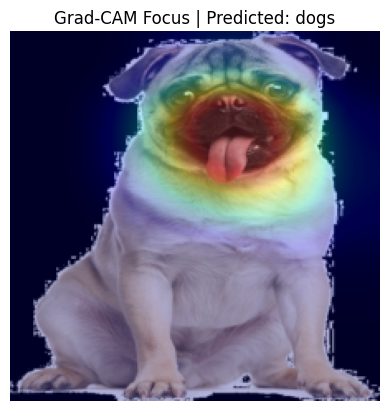

In [35]:
from google.colab import files
uploaded = files.upload()

# Run Grad-CAM on the uploaded image
predict_with_gradcam("d2.png")


In [36]:
torch.save(model.state_dict(), "finetuned_resnet18.pth")
print("Model saved to 'cat_dog_model.pth'")
from google.colab import files

# Download the saved model file
files.download('finetuned_resnet18.pth')

Model saved to 'cat_dog_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import os

# Check if the file exists
if os.path.exists("finetuned_resnet18.pth"):
    print("Model file found!")
else:
    print("Model file not found!")


Model file found!


In [38]:
import os

# List all files in current directory
print(os.listdir('.'))


['.config', 'c1.jpg', 'c2.png', 'cat_551.jpg', 'finetuned_resnet18.pth', 'drive', 'data', 'cat-dog-images.zip', 'd2.png', 'dog_464.jpg', 'dog_123.jpg', '.ipynb_checkpoints', 'best_resnet18_model_epoch_6.pth', 'cat_1.jpg', 'd1.jpg', 'sample_data']


In [39]:
import torch
from torchvision import models
import torch.nn as nn

# Rebuild the model architecture first
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 2)  # Assuming binary classification
)

# Load the saved weights
model.load_state_dict(torch.load("finetuned_resnet18.pth", map_location=torch.device('cpu')))
model.eval()

print("Model loaded successfully!")


Model loaded successfully!
